In [2]:
'''
The original paper uses a CNN, the VGG19, to obtain the feature maps of the images. So first we need to get the pretrained model (here we don't train the CNN but we train the pixels of an initial blank noise image)
Let us use better VGG16, which is perhaps easier to use
'''
# https://www.fritz.ai/style-transfer/
# https://harishnarayanan.org/writing/artistic-style-transfer/

"\nThe original paper uses a CNN, the VGG19, to obtain the feature maps of the images. So first we need to get the pretrained model (here we don't train the CNN but we train the pixels of an initial blank noise image)\nLet us use better VGG16, which is perhaps easier to use\n"

In [3]:
%matplotlib inline
import torch
import numpy as np
from tqdm import trange

In [4]:
import torchvision
import os
os.environ['TORCH_HOME'] = './models'
modelVGG16 = torchvision.models.vgg16(weights=torchvision.models.VGG16_Weights.DEFAULT)
for param in modelVGG16.parameters():
    param.require_grad = False

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to ./models/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:13<00:00, 41.6MB/s] 


In [5]:
modelVGG16.features

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

In [6]:
for k, v in modelVGG16.named_parameters():
    print(f"{k}, shape: {v.shape}")
    print(v[0])
    break
    

features.0.weight, shape: torch.Size([64, 3, 3, 3])
tensor([[[-0.5537,  0.1427,  0.5290],
         [-0.5831,  0.3566,  0.7657],
         [-0.6902, -0.0480,  0.4841]],

        [[ 0.1755,  0.0099, -0.0814],
         [ 0.0441, -0.0703, -0.2604],
         [ 0.1324, -0.1728, -0.1323]],

        [[ 0.3130, -0.1659, -0.4275],
         [ 0.4752, -0.0827, -0.4870],
         [ 0.6320,  0.0193, -0.2775]]], grad_fn=<SelectBackward0>)


In [7]:
[ p for p in modelVGG16.parameters()]

[Parameter containing:
 tensor([[[[-5.5373e-01,  1.4270e-01,  5.2896e-01],
           [-5.8312e-01,  3.5655e-01,  7.6566e-01],
           [-6.9022e-01, -4.8019e-02,  4.8409e-01]],
 
          [[ 1.7548e-01,  9.8630e-03, -8.1413e-02],
           [ 4.4089e-02, -7.0323e-02, -2.6035e-01],
           [ 1.3239e-01, -1.7279e-01, -1.3226e-01]],
 
          [[ 3.1303e-01, -1.6591e-01, -4.2752e-01],
           [ 4.7519e-01, -8.2677e-02, -4.8700e-01],
           [ 6.3203e-01,  1.9308e-02, -2.7753e-01]]],
 
 
         [[[ 2.3254e-01,  1.2666e-01,  1.8605e-01],
           [-4.2805e-01, -2.4349e-01,  2.4628e-01],
           [-2.5066e-01,  1.4177e-01, -5.4864e-03]],
 
          [[-1.4076e-01, -2.1903e-01,  1.5041e-01],
           [-8.4127e-01, -3.5176e-01,  5.6398e-01],
           [-2.4194e-01,  5.1928e-01,  5.3915e-01]],
 
          [[-3.1432e-01, -3.7048e-01, -1.3094e-01],
           [-4.7144e-01, -1.5503e-01,  3.4589e-01],
           [ 5.4384e-02,  5.8683e-01,  4.9580e-01]]],
 
 
         [[[ 1.77

In [8]:
import urllib.request  # the lib that handles the url stuff

target_url = "https://gist.githubusercontent.com/yrevar/942d3a0ac09ec9e5eb3a/raw/238f720ff059c1f82f368259d1ca4ffa5dd8f9f5/imagenet1000_clsidx_to_labels.txt"
labels = []
for line in urllib.request.urlopen(target_url):
    labels.append(line.decode('utf-8')) #utf-8 or iso8859-1 or whatever the page encoding scheme is

In [12]:
import requests, io
import matplotlib.pyplot as plt 

url = "https://www.ensembl.org/i/species/Canis_lupus_familiaris.png"
def get_image(url=url, plot=True):
    response = requests.get(url).content
    img = plt.imread(io.BytesIO(response), format='JPG')
    img = img[:,:,:3]
    if img.dtype == np.uint8: img = img/255.
    img = torch.tensor(img).float()
    height, width, ch = img.shape
    X = torch.stack([img[:,:,d] for d in range(img.shape[-1])])
    X = X.view(1,3,height,width)
    if plot: plt.imshow(X[0,0,...])
    return X

In [13]:
def classify(X):
    logits = modelVGG16(X)
    #print(logits.shape)
    prob = torch.softmax(logits, dim=1)
    #print(prob)
    #print(f"it is a {labels[prob.argmax(dim=1).item()]}")
    #print(f"prob: {prob.max(dim=1).values[0].item()}")
    
    cands = (torch.topk(prob.flatten(), 3).indices).detach().numpy()
    labls =[labels[i] for i in cands]
    probs = [prob[0][i].item() for i in cands]
    #print(cands)
    print(f"lablels: {labls}")
    print(f"probs: {probs}")
    #print(labs)
    
    return prob[0].detach().numpy()

lablels: [" 549: 'envelope',\n", " 611: 'jigsaw puzzle',\n", " 664: 'monitor',\n"]
probs: [0.333192378282547, 0.07589004933834076, 0.07070287317037582]


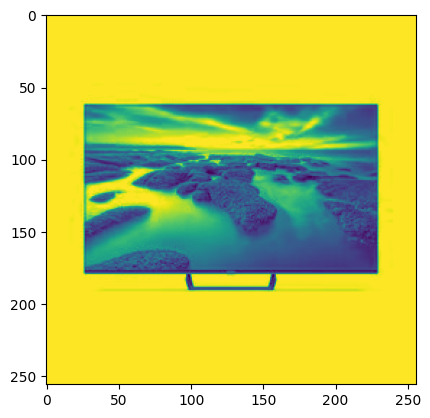

In [14]:
im = "https://cdn.computerhoy.com/sites/navi.axelspringer.es/public/media/image/legacy_bdt/xiaomi_tv_a2_55.jpg?tf=256x"
X = get_image(url=im)
probs = classify(X)

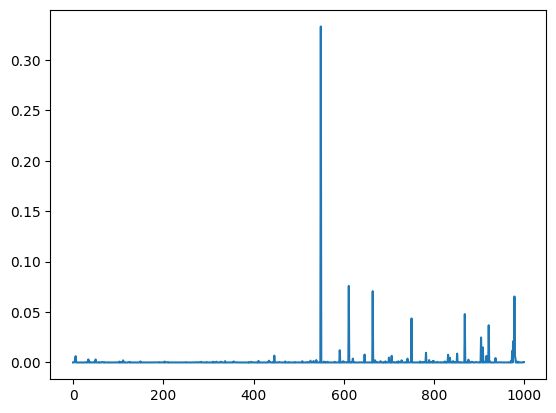

In [15]:
plt.plot(probs)